In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Definimos las rutas subiendo un nivel (..) y entrando a 'data'
# Ajusta 'data' si tu carpeta tiene otro nombre (ej. 'datasets')
PATH_VENTAS = '../data/vgsales.csv'
PATH_METACRITIC = '../data/games.csv'

# Verificación rápida de que los archivos existen en esa ruta
for path in [PATH_VENTAS, PATH_METACRITIC]:
    if os.path.exists(path):
        print(f"✅ Archivo encontrado: {path}")
    else:
        print(f"❌ No se encuentra en: {path}")

# Carga de DataFrames
df_ventas = pd.read_csv(PATH_VENTAS)
df_criticas = pd.read_csv(PATH_METACRITIC)

# Estandarización de plataformas para el merge
mapeo = {
    'Xbox 360': 'X360', 'PlayStation 3': 'PS3', 'PlayStation 4': 'PS4',
    'PlayStation 2': 'PS2', 'PC': 'PC', 'Switch': 'NS',
    'Xbox One': 'XOne', 'Wii U': 'WiiU', 'Nintendo DS': 'DS'
}
df_criticas['Platform_Std'] = df_criticas['platforms'].replace(mapeo)

# Merge de los datos
df_merged = pd.merge(
    df_ventas, 
    df_criticas, 
    left_on=['Name', 'Platform'], 
    right_on=['title', 'Platform_Std']
)

print(f"\nÉxito: Datos combinados. Filas resultantes: {len(df_merged)}")

✅ Archivo encontrado: ../data/vgsales.csv
✅ Archivo encontrado: ../data/games.csv

Éxito: Datos combinados. Filas resultantes: 1766


<Figure size 1200x800 with 0 Axes>

d:\Bridge bootcamp\Temario\Project_EDA\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Bridge bootcamp\Temario\Project_EDA\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


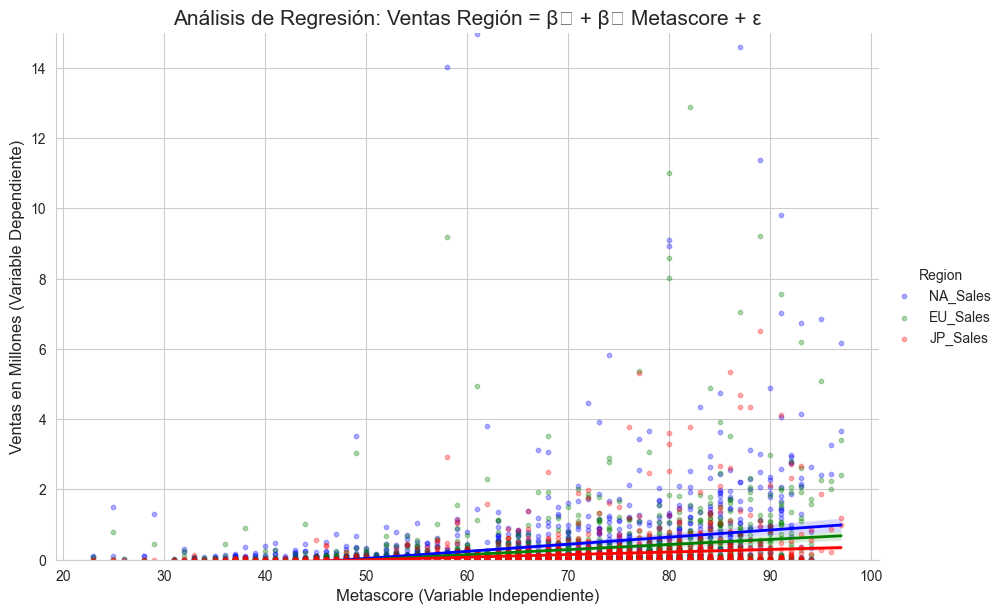

--- Validación Estadística (Coeficiente r) ---
NA_Sales: r = 0.179 (Débil)
EU_Sales: r = 0.181 (Débil)
JP_Sales: r = 0.211 (Débil)


In [18]:
# 1. Preparación de datos (formato "long" para Seaborn)
# Creamos un subset con las columnas necesarias
df_regresion = df_merged[['metascore', 'NA_Sales', 'EU_Sales', 'JP_Sales']].copy()

# Transformamos la tabla para tener una columna de 'Region' y otra de 'Ventas'
df_plot = df_regresion.melt(id_vars=['metascore'], 
                            value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales'],
                            var_name='Region', value_name='Ventas')

# 2. Creación del Diagrama de Dispersión Segmentado
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Dibujamos las regresiones para cada región
scatter_plot = sns.lmplot(
    data=df_plot, x='metascore', y='Ventas', hue='Region',
    palette={'NA_Sales': 'blue', 'EU_Sales': 'green', 'JP_Sales': 'red'},
    scatter_kws={'alpha': 0.3, 's': 10}, 
    line_kws={'linewidth': 2},
    aspect=1.5, height=6
)

# 3. Personalización según la Metodología
plt.title('Análisis de Regresión: Ventas Región = β₀ + β₁ Metascore + ε', fontsize=15)
plt.xlabel('Metascore (Variable Independiente)', fontsize=12)
plt.ylabel('Ventas en Millones (Variable Dependiente)', fontsize=12)
plt.ylim(0, 15) # Limitamos el eje Y para ver mejor las pendientes sin los outliers extremos (como Wii Sports)

plt.show()

# 4. Cálculo de Coeficientes de Pearson (r) para la validación
print("--- Validación Estadística (Coeficiente r) ---")
for reg in ['NA_Sales', 'EU_Sales', 'JP_Sales']:
    r, p = stats.pearsonr(df_regresion['metascore'], df_regresion[reg])
    interpretacion = "Fuerte" if abs(r) > 0.7 else "Moderada" if abs(r) > 0.4 else "Débil"
    print(f"{reg}: r = {r:.3f} ({interpretacion})")

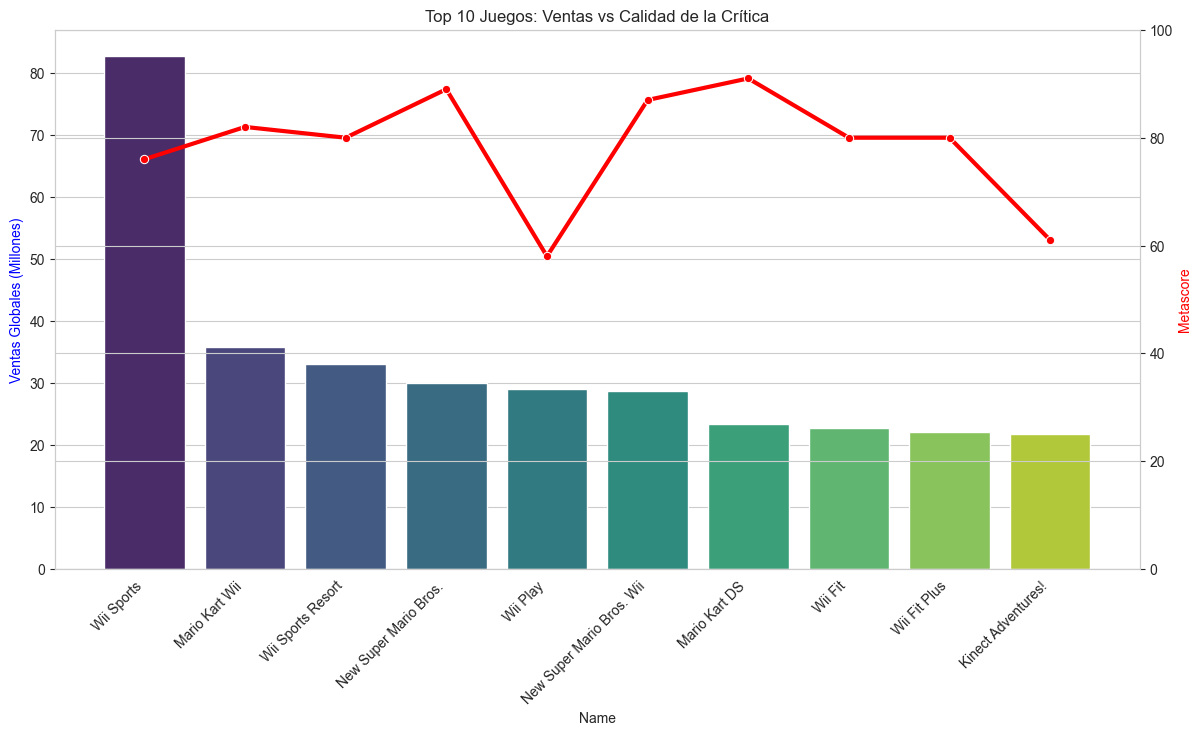

In [20]:

# 4. Limpieza de datos
# Convertir userscore a numérico (maneja los 'tbd' como NaN)
df_merged['userscore'] = pd.to_numeric(df_merged['userscore'], errors='coerce')
df_merged = df_merged.dropna(subset=['metascore', 'Global_Sales'])

# --- VISUALIZACIÓN 2: Top 10 Juegos por Ventas y su Calidad ---
top_10 = df_merged.nlargest(10, 'Global_Sales')
fig, ax1 = plt.subplots(figsize=(14, 7))

# Barras para Ventas
sns.barplot(data=top_10, x='Name', y='Global_Sales', ax=ax1, hue='Name', palette='viridis')
ax1.set_ylabel('Ventas Globales (Millones)', color='b')
plt.xticks(rotation=45, ha='right')

# Línea para Metascore (Eje secundario)
ax2 = ax1.twinx()
sns.lineplot(data=top_10, x='Name', y='metascore', ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('Metascore', color='r')
ax2.set_ylim(0, 100)

plt.title('Top 10 Juegos: Ventas vs Calidad de la Crítica')
plt.show()

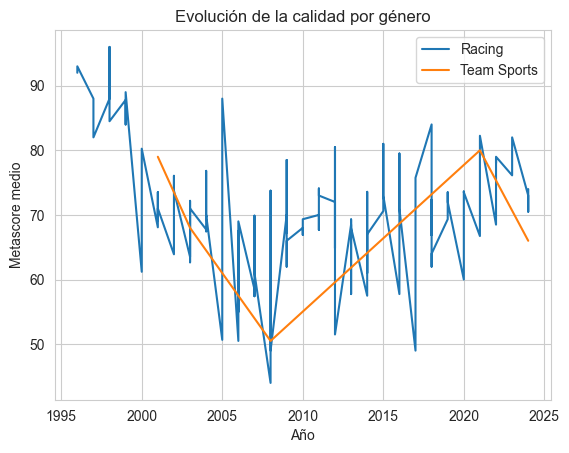

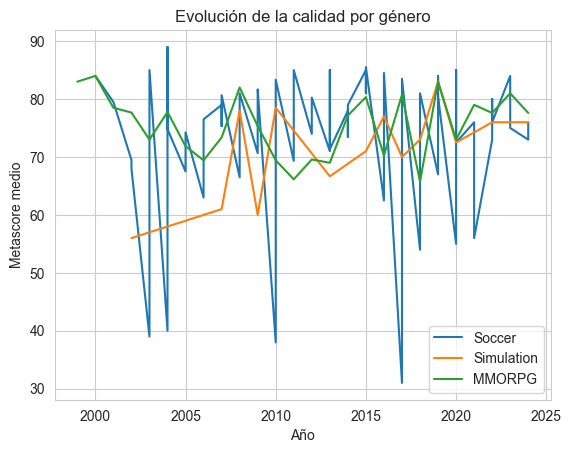

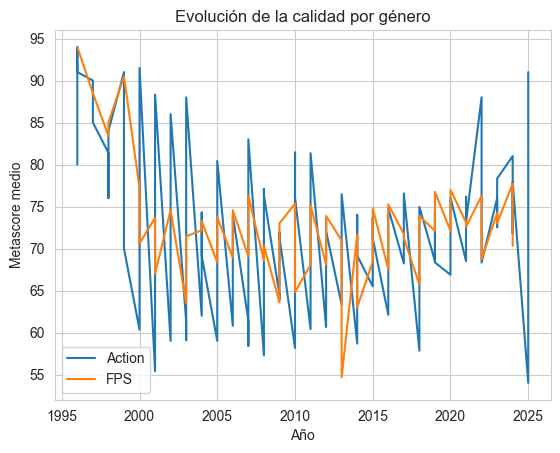

In [25]:
df_criticas['releaseDate'] = pd.to_datetime(df_criticas['releaseDate'], errors='coerce')
df_criticas['year'] = df_criticas['releaseDate'].dt.year.astype('Int64')
df_clean = df_criticas.dropna(subset=['year', 'metascore', 'genres'])

genres_of_interest = [['Racing','Team Sports'],['Soccer', 'Simulation', 'MMORPG'],['Action', 'FPS']]

for genre_group in genres_of_interest:
    df_genres = df_clean[
        df_clean['genres'].str.contains('|'.join(genre_group), case=False, na=False)
    ]

    quality_by_year = (
        df_genres
        .groupby(['year', 'genres'])['metascore']
        .mean()
        .reset_index()
    )

    fig, ax = plt.subplots()

    for genre in genre_group:
        data = quality_by_year[quality_by_year['genres'].str.contains(genre)]
        ax.plot(data['year'], data['metascore'], label=genre)

    ax.set_xlabel('Año')
    ax.set_ylabel('Metascore medio')
    ax.set_title('Evolución de la calidad por género')
    ax.legend()

    plt.show()

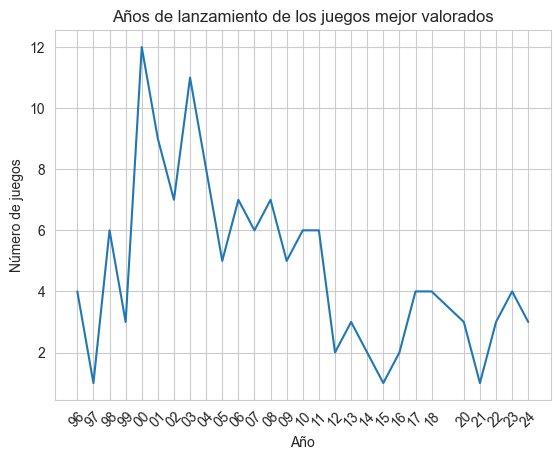

In [27]:
threshold = df_criticas['metascore'].quantile(0.99)

top_1_percent = df_criticas[df_criticas['metascore'] >= threshold]

counts = top_1_percent['year'].value_counts().sort_index()
fig, ax = plt.subplots()

ax.plot(counts.index, counts.values)
ax.set_xticks(counts.index)
ax.set_xticklabels([f"{year % 100:02d}" for year in counts.index], rotation=45)

ax.set_xlabel('Año')
ax.set_ylabel('Número de juegos')
ax.set_title('Años de lanzamiento de los juegos mejor valorados')

plt.show()

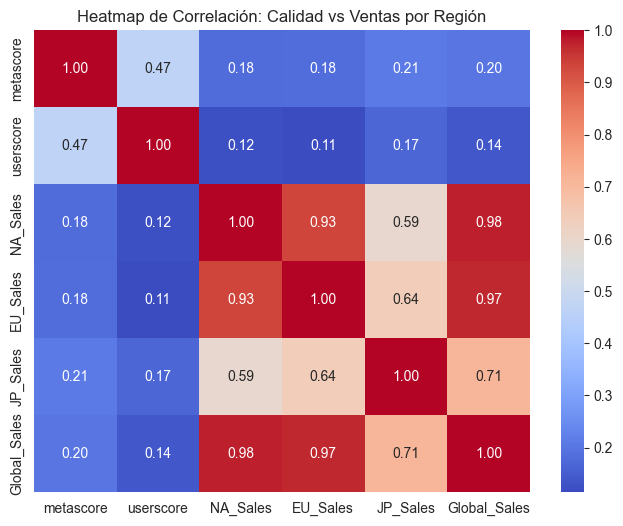

In [28]:
cols_corr = ['metascore', 'userscore', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']
plt.figure(figsize=(8, 6))
sns.heatmap(df_merged[cols_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlación: Calidad vs Ventas por Región')
plt.show()

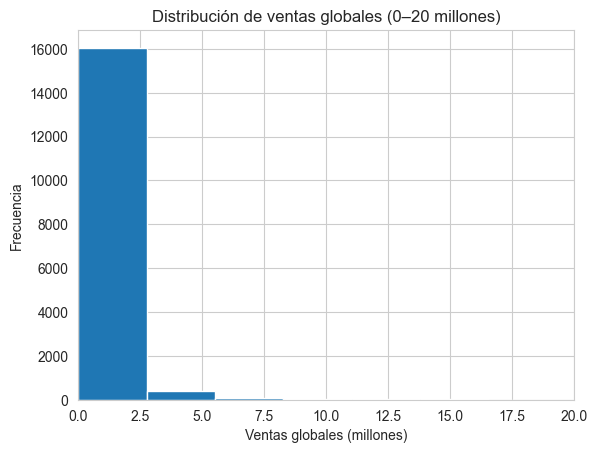

In [30]:
plt.figure()
plt.hist(df_ventas['Global_Sales'], bins=30)
plt.xlim(0, 20)
plt.xlabel('Ventas globales (millones)')
plt.ylabel('Frecuencia')
plt.title('Distribución de ventas globales (0–20 millones)')
plt.show()

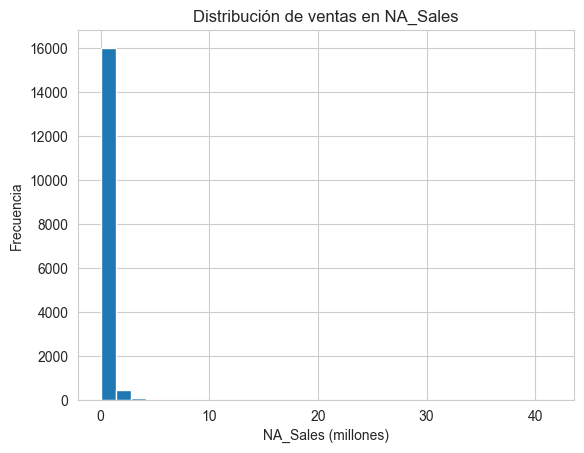

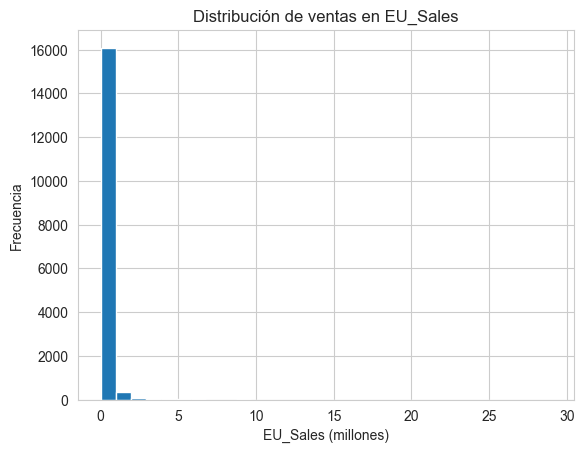

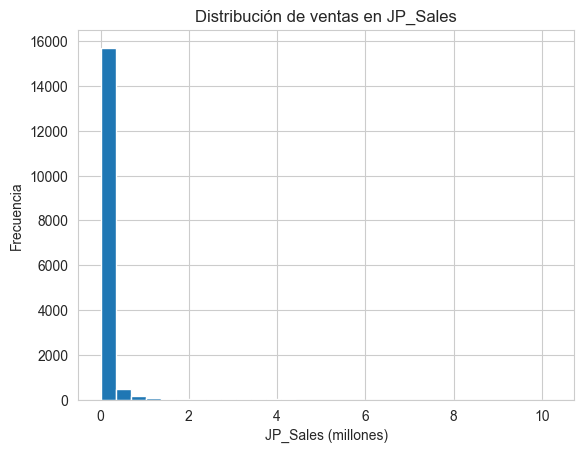

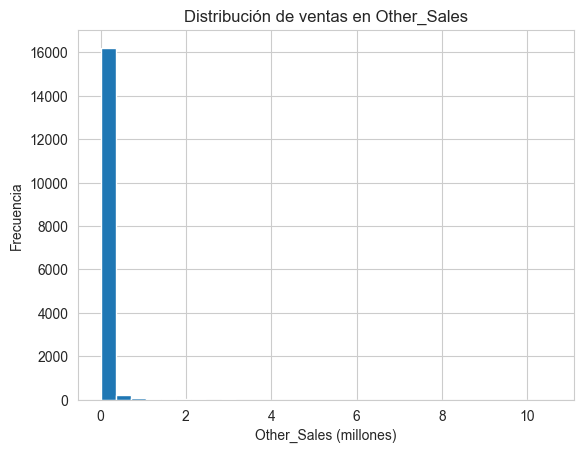

In [31]:
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for region in regions:
    plt.figure()
    plt.hist(df_ventas[region], bins=30)
    plt.xlabel(f'{region} (millones)')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución de ventas en {region}')
    plt.show()